# LSTM of power meter


### Attributes
1. date: Date in format dd/mm/yyyy

2. time: Time in format hh:mm:ss

3. global_active_power: household global minute-averaged active power (in kilowatt)
Active power is the power that continuously flows from source to load in an electric circuit. 

4. global_reactive_power: household global minute-averaged reactive power (in kilowatt)
Reactive power is the power that continuously flows from source to load and returns back to source in an electric circuit.

5. voltage: minute-averaged voltage (in volt)

6. global_intensity: household global minute-averaged current intensity (in ampere)

7. sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).

8. sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing machine, a tumble-drier, a refrigerator and a light.

9. sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water heater and an air-conditioner.


## Some Libraries we may need

In [87]:
import sys 
import numpy as np 
from scipy.stats import randint
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold 
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics 
from sklearn.metrics import mean_squared_error,r2_score
# LSTM-related
import keras
from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout
print('Library importing complete')

Library importing complete


## Importing the dataset

 - Dataset includes 'nan' and '?' as a string, both of which can be converted to numpy nan during the importing stage.
 - 'Date' and 'Time' are merged into one column 'dt'. 
 - 'dt' is treated as the time-based index in the data frame.

In [88]:
data = pd.read_csv('household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')
print('Data importing complete')

Data importing complete


## Qucik review of the dataset

In [89]:
data.head() 

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


## Imputing missing values (NaN) with a test statistic

In [90]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
temp = data.copy()
imputer.fit(temp)
temp = imputer.transform(temp)
data = pd.DataFrame(temp, index=data.index,
                    columns=['Global_active_power','Global_reactive_power','Voltage','Global_intensity',
                             'Sub_metering_1','Sub_metering_2','Sub_metering_3'])

In [91]:
# Sanity check to make sure that there are no more NaN
data.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

## Data visualization

### 1. Global_active_power resampled over day via sum and mean. 

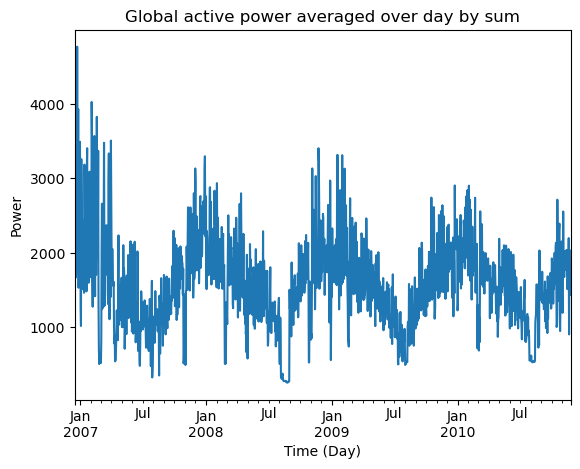

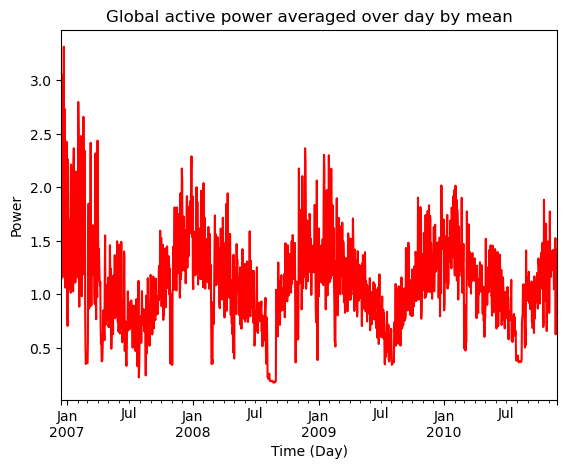

In [92]:
data.Global_active_power.resample('D').sum().plot(title='Global active power averaged over day by sum') 
plt.ylabel('Power')
plt.xlabel('Time (Day)')
plt.show()   
data.Global_active_power.resample('D').mean().plot(title='Global active power averaged over day by mean', color='red') 
plt.ylabel('Power')
plt.xlabel('Time (Day)')
plt.show()

- Similar oscillatory characteristics between mean and sum were shown above.

### 2.'Global_active_power' resampled over month and over quarter

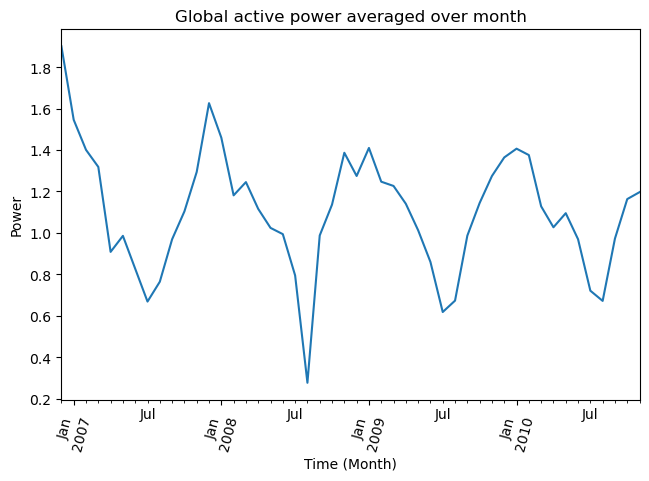

In [93]:
data['Global_active_power'].resample('M').mean().plot(title='Global active power averaged over month')
plt.tight_layout()
plt.xticks(rotation=75)
plt.ylabel('Power')
plt.xlabel('Time (Month)')
plt.show()

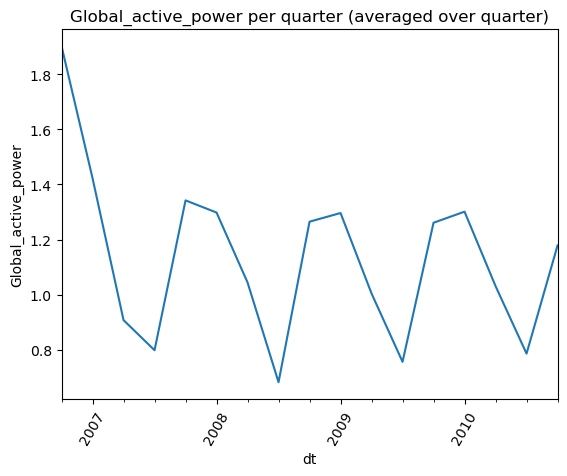

In [94]:
data['Global_active_power'].resample('Q').mean().plot(title='Global_active_power per quarter (averaged over quarter)')
plt.xticks(rotation=60)
plt.ylabel('Global_active_power')
plt.show()

- A low-pass filtering effect was observed, which is a common technique in data preprocessing. Data was smoothened.

### 3. Correlations between different data attributes

## Data preprocessing

* Goal: predicting the Global_active_power at the current time (t) given the Global_active_power measurement and other features at the prior time step (t-1). Thus, need to re-organize the data into this time-sequence format. 

In [95]:
# Resample the data over hour
# In order to reduce the computation time, data is resampled over hour (the original data are given in minutes). 
# This will reduce the size of data from 2075259 to 34589. 
data_resampled = data.resample('h').mean() 
data_resampled.shape

(34589, 7)

### 1. Feature scaling

In [96]:
values = data_resampled.values 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

### 2. Data reframing based on time
* input: [var1(t-1), var2(t-1), var3(t-1), var4(t-1), var5(t-1), var6(t-1)] and prediction: var1(t)

In [97]:
def time_series_reframing(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # Input sequence (t-1, ..., t-n)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # Concatenate the input and forecast sequence
    reframed = pd.concat(cols, axis=1)
    reframed.columns = names
    # Drop rows with NaN values
    if dropnan:
        reframed.dropna(inplace=True)
    return reframed
 
reframed = time_series_reframing(scaled, 1, 1)
print('Reframed:')
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
print(reframed.head())

Reframed:
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.636816   0.295738   0.337945   0.631157        0.0   0.011366   
2   0.545045   0.103358   0.335501   0.541487        0.0   0.144652   
3   0.509006   0.110073   0.283802   0.502152        0.0   0.030869   
4   0.488550   0.096987   0.315987   0.481110        0.0   0.000000   
5   0.455597   0.099010   0.434417   0.449904        0.0   0.008973   

   var7(t-1)   var1(t)  
1   0.782418  0.545045  
2   0.782676  0.509006  
3   0.774169  0.488550  
4   0.778809  0.455597  
5   0.798917  0.322555  


* 7 input variables (input series at t-1) and 1 output variable 'Global_active_power' at the current time (t) in hour. 

### 2. Splitting the data to train and test sets

In [98]:
values = reframed.values
X, y = values[:,:-1], values[:,-1]
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = 0)
print(values.shape, train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(34588, 8) (27670, 7) (27670,) (6918, 7) (6918,)


### 3. Reshaping the data inputs into 3D format as required by LSTM
3D shape [samples, timesteps, input_dim (or # of features)]

In [99]:
# Reshape the input into the 3D format as expected by LSTMs, namely [samples, timesteps, input_dim (or # of features)].
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, test_X.shape, '; # of time steps = ', train_X.shape[1], 'and # of features = ', train_X.shape[2]) 

(27670, 1, 7) (6918, 1, 7) ; # of time steps =  1 and # of features =  7


![alt text](LSTM.png "Title")

## Training and testing the LSTM network
<img src="LSTMarch.PNG" alt="Drawing" style="width: 500px;"/>

* LSTM mainly consists of 3 gates: forget, input, and output gates, and 2 states: cell (long-term memory) and hidden state (short term memory).
* Forget gate: decide what information to keep from the previous step
* Input gate: evaluate the importance of new input information at thhe current step
* Output gate: decide what the next hidden state should be


Python pseudo code:

<img src="code.png" alt="Drawing" style="width: 500px;"/>

### 1. Building and compiling the network
* Model architecture
* LSTM with 100 neurons in the first visible layer 
* 1 neuron in the output layer for predicting Global_active_power. 
* The input shape will be 1 time step with 7 features.
* The Mean Squared Error (MSE) loss function is used and the efficient Adam version of stochastic gradient descent.
* The model will be fit for 20 training epochs with a batch size of 70.

In [100]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))

# model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

### 2. Training the network

In [101]:
history = model.fit(train_X, train_y, epochs=100, batch_size=50, validation_data=(test_X, test_y), verbose=1, shuffle=False)


Epoch 1/100
554/554 [==============================] - 10s 8ms/step - loss: 0.0103 - val_loss: 0.0088
Epoch 2/100
554/554 [==============================] - 3s 5ms/step - loss: 0.0090 - val_loss: 0.0087
Epoch 3/100
554/554 [==============================] - 3s 5ms/step - loss: 0.0090 - val_loss: 0.0087
Epoch 4/100
554/554 [==============================] - 3s 5ms/step - loss: 0.0090 - val_loss: 0.0087
Epoch 5/100
554/554 [==============================] - 3s 5ms/step - loss: 0.0089 - val_loss: 0.0086
Epoch 6/100
554/554 [==============================] - 3s 5ms/step - loss: 0.0089 - val_loss: 0.0086
Epoch 7/100
554/554 [==============================] - 3s 5ms/step - loss: 0.0089 - val_loss: 0.0086
Epoch 8/100
554/554 [==============================] - 3s 5ms/step - loss: 0.0089 - val_loss: 0.0086
Epoch 9/100
554/554 [==============================] - 3s 5ms/step - loss: 0.0089 - val_loss: 0.0086
Epoch 10/100
554/554 [==============================] - 3s 5ms/step - loss: 0.0089 - val_l

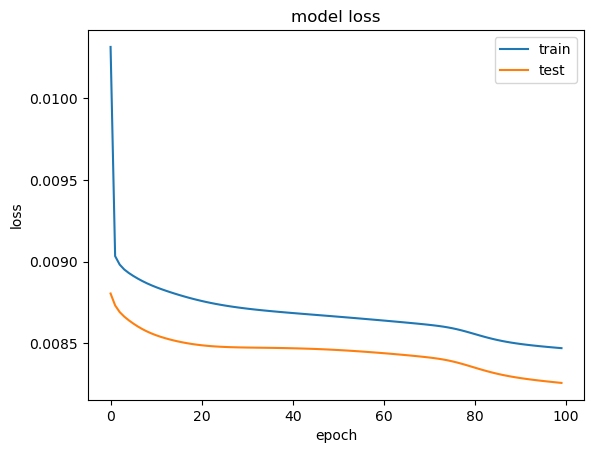

In [102]:
# Plot the learning curve
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

### 3. Testing the trained model

In [103]:
# Make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 7))

#  predictionInvert scaling for
inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# Invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

217/217 [==============================] - 2s 2ms/step


In [104]:
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE =  %.3f' % rmse)

Test RMSE =  0.585


* Note that network parameters such as Epochs and batch_size can be tuned to improve the model performance.

#### Increased the batch size to decrease the RMSE value